In [69]:
import cv2
import pickle
import matplotlib.pyplot as plt

# Load calibration data
with open("./data/stereo_calibration.pkl", "rb") as f:
    data = pickle.load(f)

print(data.keys())

cameraMatrix1 = data['left_K']
distCoeffs1   = data['left_dist']
cameraMatrix2 = data['right_K']
distCoeffs2   = data['right_dist']
R             = data['R']
T             = data['T']
image_size    = data['image_size']

# Compute rectification transforms
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cameraMatrix1,
    distCoeffs1,
    cameraMatrix2,
    distCoeffs2,
    image_size,
    R,
    T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=-1
)

# print("P1:\n", P1)
# print("P2:\n", P2)


dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])


In [70]:
with open("./data/stereo_calibration.pkl", "rb") as f:
    calib = pickle.load(f)
print(calib.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])


In [71]:
with open("./data/stereo_maps.pkl", "rb") as f:
    calib = pickle.load(f)
print(calib.keys())

dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


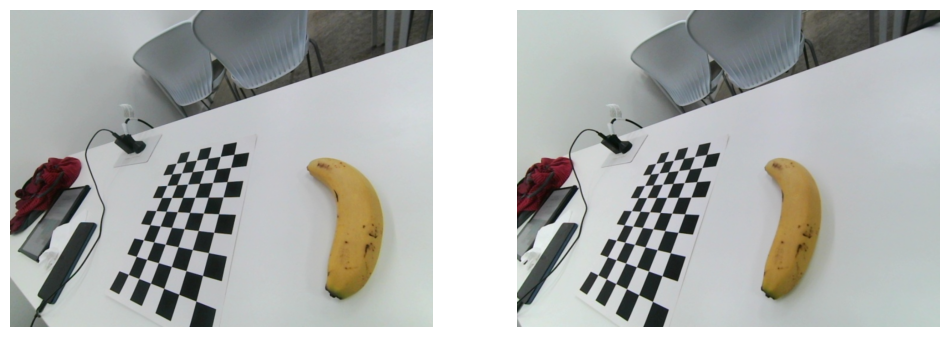

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

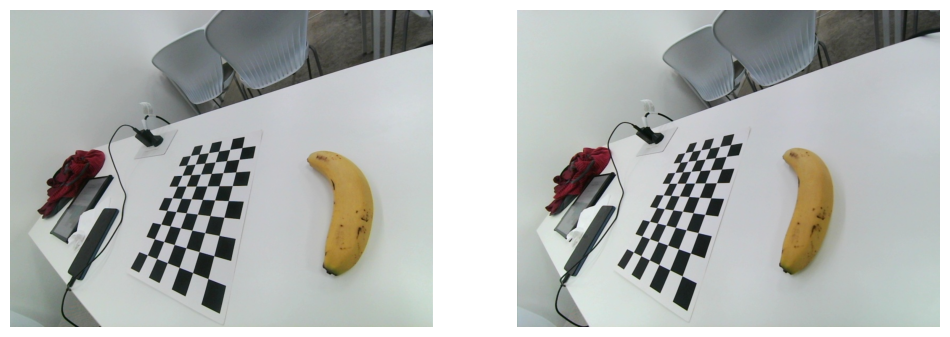

In [72]:
# Mapas de rectificación (izquierda y derecha)
left_image=cv2.imread("./fotos_objetos/left_2.jpg")
right_image=cv2.imread("./fotos_objetos/right_2.jpg")

left_image  = cv2.cvtColor(left_image,  cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

# map1x, map1y = cv2.initUndistortRectifyMap(
#     cameraMatrix1, distCoeffs1, R1, P1, image_size, cv2.CV_32FC1
# )

# map2x, map2y = cv2.initUndistortRectifyMap(
#     cameraMatrix2, distCoeffs2, R2, P2, image_size, cv2.CV_32FC1
# )

# # Aplicar los mapas a las imágenes
# left_rectified  = cv2.remap(left_image,  map1x, map1y, cv2.INTER_LINEAR)
# right_rectified = cv2.remap(right_image, map2x, map2y, cv2.INTER_LINEAR)

with open("./data/stereo_maps.pkl", "rb") as f:
    maps = pickle.load(f)

left_map_x = maps["left_map_x"]
left_map_y = maps["left_map_y"]
right_map_x = maps["right_map_x"]
right_map_y = maps["right_map_y"]

left_rectified  = cv2.remap(left_image,  left_map_x,  left_map_y,  cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_rectified)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_rectified)
plt.axis("off")

plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_image)
plt.axis("off")

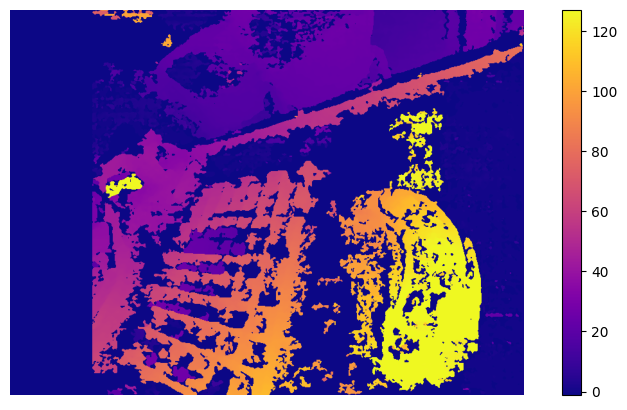

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Create StereoSGBM matcher
window_size = 5
min_disp = 0
num_disp = 16*8  # must be divisible by 16

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8*3*window_size**2,
    P2=32*3*window_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(left_rectified, right_rectified).astype(np.float32) / 16.0

# Optional: normalize for visualization
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.axis('off')
plt.show()



In [74]:
# en esta celda se extraen los parametros del stereo_calibration.pkl para poder hacer lo de la tutorial 6

with open("./data/stereo_calibration.pkl", "rb") as f:
    calib = pickle.load(f)

# Intrinsic matrices
K1 = calib['left_K']
K2 = calib['right_K']

# K = [[fx, 0, cx],
#      [0, fy, cy],
#      [0,  0,  1]]

fx  = K1[0, 0]
fy  = K1[1, 1]
cx0 = K1[0, 2]  # principal point x of left camera
cy0 = K1[1, 2]  # principal point y of left camera

# cx1 is from the rectified right projection matrix P2
# Compute rectification first:
R = calib['R']
T = calib['T']
image_size = calib['image_size']
dist1 = calib['left_dist']
dist2 = calib['right_dist']

R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K1, dist1,
    K2, dist2,
    image_size, R, T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
)

cx1 = P2[0, 2]  # principal point x of rectified right camera


models/crestereo_combined_iter5_720x1280.onnx


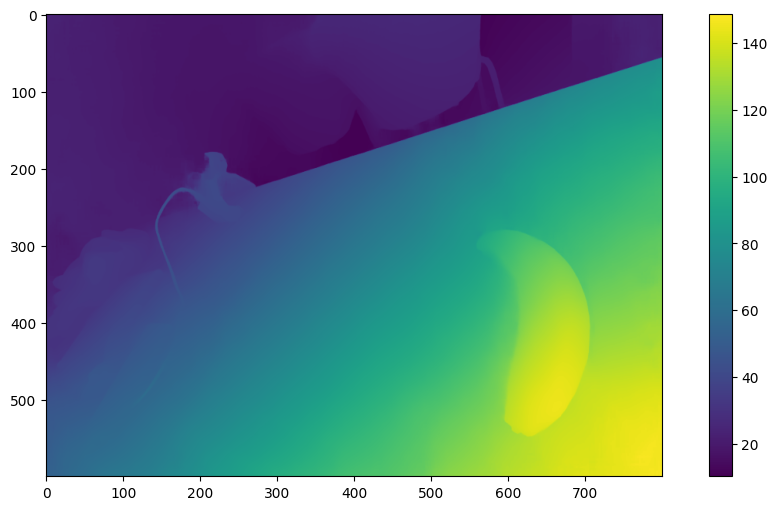

In [75]:
# copiado y pegado de la tutorial 6


w, h = left_image.shape[1], left_image.shape[0]

# fx = left_K[0][0]
# fy = left_K[1][1]
# cx0 = left_K[0][2]
# cy0 = left_K[1][2]

baseline = np.linalg.norm(T)



# Cre Stereo

import cv2
import json
import numpy as np
from pathlib import Path


from disparity.method_cre_stereo import CREStereo
from disparity.method_opencv_bm import StereoBM, StereoSGBM
from disparity.methods import Calibration, InputPair, Config


calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})



import os

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)




#models_path = Path.home() / ".cache" / "stereodemo" / "models"
models_path = Path(models_path)
pair = InputPair(left_rectified, right_rectified, calibration)
# pair = InputPair(left_image, right_image, calibration)
config = Config(models_path=models_path)

# params = {
#    "Shape": "1280x720",
#    "Mode": "combined",
#    "Iterations": 20
#}
method = CREStereo(config)

#method.parameters["Shape"].set_value("640x480")
method.parameters["Shape"].set_value("1280x720")
# method.parameters["Iterations"].set_value("10")

#method.parameters.update(params)
# method = StereoBM(config)
# method = StereoSGBM(config)
# method = StereoBM(config)
disparity = method.compute_disparity(pair)





plt.figure(figsize=(12, 6))
plt.imshow(disparity.disparity_pixels)
plt.colorbar()
plt.show()

In [76]:
# copypaste del pdf consigna, seccion 5, usando el modulo calib de la tutorial 6

import calib
checkerboard=(9,6)
cuadradito_size_mm=20
left_rectified_gray=cv2.cvtColor(left_rectified,cv2.COLOR_RGB2GRAY)
left_rectified_gray = left_rectified_gray.astype(np.uint8)

left_found,left_corners=calib.detect_board(checkerboard,left_rectified_gray)

object_3dpoints=calib.board_points(checkerboard)
object_3dpoints_mm=object_3dpoints*cuadradito_size_mm

ret,rvec,tvec=cv2.solvePnP(object_3dpoints_mm,left_corners,K1,dist1,flags=cv2.SOLVEPNP_IPPE)

c_R_o_left=cv2.Rodrigues(rvec)     # camera to object rotation
c_T_o_left=np.column_stack((c_R_o_left[0],tvec))    # camera to object transformation
c_T_o_left=np.vstack((c_T_o_left,[0,0,0,1]))
o_T_c_left=np.linalg.inv(c_T_o_left)        # object to camera transformation

In [77]:
import calib
checkerboard=(9,6)
cuadradito_size_mm=20
right_rectified_gray=cv2.cvtColor(right_rectified,cv2.COLOR_RGB2GRAY)
right_rectified_gray = right_rectified_gray.astype(np.uint8)

right_found,right_corners=calib.detect_board(checkerboard,right_rectified_gray)

object_3dpoints=calib.board_points(checkerboard)
object_3dpoints_mm=object_3dpoints*cuadradito_size_mm

ret,rvec,tvec=cv2.solvePnP(object_3dpoints_mm,right_corners,K2,dist2,flags=cv2.SOLVEPNP_IPPE)

c_R_o_right=cv2.Rodrigues(rvec)     # camera to object rotation
c_T_o_right=np.column_stack((c_R_o_right[0],tvec))    # camera to object transformation
c_T_o_right=np.vstack((c_T_o_right,[0,0,0,1]))
o_T_c_right=np.linalg.inv(c_T_o_right)        # object to camera transformation

In [78]:
# import numpy as np
# import open3d as o3d
# import cv2

# # --- Supongamos que ya tenés estas poses ---
# # c_T_o_left y c_T_o_right: del solvePnP
# # Por ejemplo:
# # c_T_o_left  = np.array([...])
# # c_T_o_right = np.array([...])

# # Invertimos para obtener cámara respecto al tablero
# o_T_cL = np.linalg.inv(c_T_o_left)
# o_T_cR = np.linalg.inv(c_T_o_right)

# # Transformación derecha respecto a izquierda
# cL_T_cR = np.linalg.inv(o_T_cL) @ o_T_cR

# # --- Visualización en Open3D ---
# frames = []

# # Eje del tablero (sistema de referencia del mundo)
# frame_tablero = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=[0, 0, 0])
# frames.append(frame_tablero)

# # Eje cámara izquierda
# frame_left = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
# frame_left.transform(o_T_cL)  # posicionamos en el mundo
# frames.append(frame_left)

# # Eje cámara derecha
# frame_right = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
# frame_right.transform(o_T_cR)
# frames.append(frame_right)

# # Visualización
# o3d.visualization.draw_geometries(frames)


In [82]:
print(type(disparity))
print(dir(disparity))

disp = disparity.disparity_pixels.astype(np.float32)
points_3D = cv2.reprojectImageTo3D(disp, Q)

# Mask invalid points
mask = disp > 0
points = points_3D[mask]
colors = left_rectified[mask] / 255.0  # normalize colors to [0, 1]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])



<class 'disparity.methods.StereoOutput'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'color_image_bgr', 'computation_time', 'disparity_color', 'disparity_pixels', 'point_cloud']


In [80]:
# # intento de visualizar ejes y nube de puntos a la vez

# # --- Step 1: Get disparity as numpy array ---
# disp = disparity.disparity_pixels.astype(np.float32)

# # --- Step 2: Reproject to 3D ---
# points_3D = cv2.reprojectImageTo3D(disp, Q)

# # Mask invalid points
# mask = disp > 0
# points = points_3D[mask]
# colors = left_rectified[mask] / 255.0  # normalize to [0,1]

# # o_T_cL is the 4x4 homogeneous matrix: camera -> world
# points_h = np.hstack([points, np.ones((points.shape[0], 1))])  # make homogeneous
# points_world = (o_T_cL @ points_h.T).T[:, :3]                  # transform to world

# # --- Step 3: Create Open3D point cloud ---
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_world)
# pcd.colors = o3d.utility.Vector3dVector(colors)

# # --- Step 4: Create axes (frames) ---
# # frame for the board (world origin)
# frame_board = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=[0, 0, 0])

# # frames for left and right cameras
# frame_left = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
# frame_left.transform(o_T_cL)  # transform to world coordinates

# frame_right = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
# frame_right.transform(o_T_cR)

# # --- Optional: convert OpenCV camera axes to Open3D convention ---
# flip = np.array([[1, 0, 0, 0],
#                  [0, -1, 0, 0],
#                  [0, 0, -1, 0],
#                  [0, 0, 0, 1]], dtype=float)
# frame_left.transform(flip)
# frame_right.transform(flip)

# # --- Step 5: Visualize all together ---
# o3d.visualization.draw_geometries([pcd, frame_board, frame_left, frame_right])


In [81]:

# # =========================
# # Step 1: Get disparity as numpy array
# # =========================
# disp = disparity.disparity_pixels.astype(np.float32)

# # =========================
# # Step 2: Reproject to 3D (in left camera coordinates)
# # =========================
# points_3D = cv2.reprojectImageTo3D(disp, Q)

# # Mask invalid points
# mask = disp > 0
# points = points_3D[mask]
# colors = left_rectified[mask] / 255.0  # normalize to [0,1]

# # =========================
# # Step 3: Transform points to world/board coordinates
# # =========================
# # points_h: homogeneous coordinates
# points_h = np.hstack([points, np.ones((points.shape[0], 1))])

# # Transform to world using left camera pose
# points_world = (o_T_cL @ points_h.T).T[:, :3]

# # =========================
# # Step 4: Apply OpenCV → Open3D flip so Y points up
# # =========================
# flip = np.array([[1, 0, 0, 0],
#                  [0, -1, 0, 0],
#                  [0, 0, -1, 0],
#                  [0, 0, 0, 1]], dtype=float)

# points_h_world = np.hstack([points_world, np.ones((points_world.shape[0], 1))])
# points_world_flipped = (flip @ points_h_world.T).T[:, :3]

# # =========================
# # Step 5: Create Open3D point cloud
# # =========================
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_world_flipped)
# pcd.colors = o3d.utility.Vector3dVector(colors)

# # =========================
# # Step 6: Create axes (frames)
# # =========================
# frame_board = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=[0,0,0])

# frame_left = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
# frame_left.transform(o_T_cL)
# frame_left.transform(flip)

# frame_right = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
# frame_right.transform(o_T_cR)
# frame_right.transform(flip)

# # =========================
# # Step 7: Visualize all together
# # =========================
# o3d.visualization.draw_geometries([pcd, frame_board, frame_left, frame_right])
